# Trabalho 1 - Simulação de um sistema não linear e suas caracteristicas

## Aluno:
- Nome: Felipe Fonseca Rocha
- Matrícula: 2015117096

## Sistema escolhido
![tanques](tanques.png)

O modelo escolhido é o de controle de nível em dois tanques acoplados, sendo a definição das variáveis de estado:

$
\dot{y_1} = \frac{U_{in} - 2U_{12} + U_{out}}{A}
$

$
\dot{y_2} = \frac{15U_{12} - U_{out}}{A}
$

Onde:

$
U_{12} = a_{12}\sqrt{2gz_1}
$

$
U_{out} = a_{2}\sqrt{2gz_2}
$


Os parametros utilizados são

## Classificação do sistema

| Variável   |    Valor             |
|:----------:|:-------------:       |
| $A$        |    $ 208 cm^3 $            |
| $a_2$        |    $ 0.24cm^2 $  |
| $a_{12}$        |    $ 0.58cm^2 $            |
| $U_{in}$        |    $ 0 < U_{in} < 50 cm^3 $            |

In [117]:
import math
import random

import matplotlib as mpl
# from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


plt.style.use('fivethirtyeight')
# plt.style.use('dark_background')
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['lines.linewidth'] = 2
#$\omega_n = A_1y_1^4 + B_1y_1³ + C_1 y_1² + D_1y_1 + E_1$

### Definição das equações de estado

In [118]:
def dvCord(x, ux, uy, t):
    # a = 0.258
    # b = 4.033
    # F = 8
    A= 208 #cm3
    a_2 = 0.24 #cm2
    a_12 =  0.58 #cm2
    U_in = (5 * ux + 20) if (5 * ux + 20) < 50 else 50
    g = 981 #cm/s2

    xd = np.array(np.zeros((2, 1)))

    U_12 = a_12 * math.sqrt( 2 * g * x[0] )
    U_out = a_2 * math.sqrt( 2 * g * x[1] )
    #
    # if U_out > 0 :
    #     print(f'Uin {U_in}; U_12 {U_12}, U_out {U_out}')

    U1 = (U_in - 2 * U_12 + U_out)
    U2 = (U_12 - U_out)
    xd[0] = U1 / A
    xd[1] = U2 / A
    return xd.copy()


### Definição de Runge-Kutta

In [119]:
def rk_cord(x0, ux, uy, h, t):
    # 1st evaluation
    xd = dvCord(x0, ux, uy, t)
    savex0 = x0.copy()
    phi = xd.copy()
    for i in range(len(x0)):
        x0[i] = savex0[i] + 0.5 * h * xd[i]

    # 2nd evaluation
    xd = dvCord(x0.T, ux, uy, t + 0.5 * h)
    phi = (phi + 2 * xd)
    for i in range(len(x0)):
        x0[i] = savex0[i] + 0.5 * h * xd[i]

    # 3rd evaluation
    xd = dvCord(x0, ux, uy, t + 0.5 * h)
    phi = phi + 2 * xd
    for i in range(len(x0)):
        x0[i] = savex0[i] + h * xd[i]

    # 4th evaluation
    xd = dvCord(x0, ux, uy, t + h)

    result_x = x0.copy()
    for i in range(len(x0)):
        result_x[i] = savex0[i] + (phi[i] + xd[i]) * h / 6

    # Restrição de nivel

    return result_x


### Plot das funções

In [120]:
def run_rk(t:np.ndarray, x:np.ndarray, u, h):
    result = None
    for k in range(1, len(t)):
        result = rk_cord(x[:, k - 1].copy(), u[k], u[k], h, t[k])
        x[:, k] = result
    color = list(set(['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(100)]))
    set_color = random.sample(range(len(color)),3)
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 4))
    ax0 = ax.twinx()
    ax.set(xlabel='time')
    ax.set(ylabel='Tensão (V)')
    p1, = ax.plot(t, u+4, 'g-', label='Entrada')
    ax.grid()
    # fig0, ax0 = plt.subplots(constrained_layout=True, figsize=(8, 4))
    ax0.set(xlabel='time')
    ax0.set(ylabel='Nível (cm)')
    # ax0.plot(t, x[0, :], color=color[set_color[1]],label='$H_1$')
    p2, = ax0.plot(t, x[1, :], 'r-' ,label='$H_2$')
    lines = [p1,p2]
    ax.legend(lines, [l.get_label() for l in lines])
    ax.yaxis.label.set_color(p1.get_color())
    tkw = dict(size=4, width=1.5)
    ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    ax0.yaxis.label.set_color(p2.get_color())
    ax0.tick_params(axis='y', colors=p2.get_color(), **tkw)
    # fig2, ax2 = plt.subplots(constrained_layout=True, figsize=(8, 4))
    # ax2.set(xlabel='time')
    # ax2.set(ylabel='x_3')
    # ax2.plot(t, x[2, :], color=color[random.randint(0, len(color) - 1)])
    # ax2.grid()
    plt.show()

### Definições dos parâmetros
 Paramêtros da simulação são os tempos de resposta em segundos:

In [121]:
t0 = 0
tf = 1500
h = 1
t = np.arange(t0, tf, h)

# [print(i) for i in t if i < 0.1]

x0 = np.array([[.5], [8]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)

print(x)

[[0.5 0.  0.  ... 0.  0.  0. ]
 [8.  0.  0.  ... 0.  0.  0. ]]


### Resposta ao Degrau ponto de operação de de 8 e 8

L: 150; R: 1350


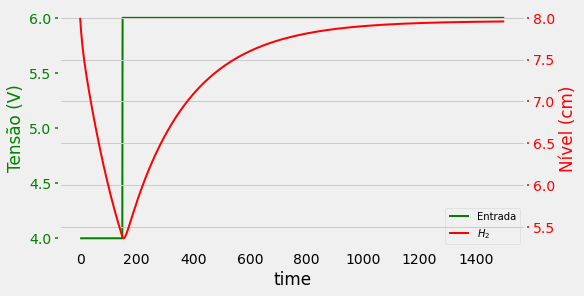

In [122]:
# Degrau
left_size = math.floor(len(t)/10)
right_size = math.floor(len(t) - len(t)/10)
print(f'L: {left_size}; R: {right_size}')
left = np.zeros((left_size, 1))
right = np.ones(right_size)
# print(f'L: {left}; R: {right}')
u = 2 * np.append(left,right)
run_rk(t.copy() ,x.copy(), u.copy() , h)


### Resposta ao Impulso
Imperceptivel devido a unidade de medida do sistema

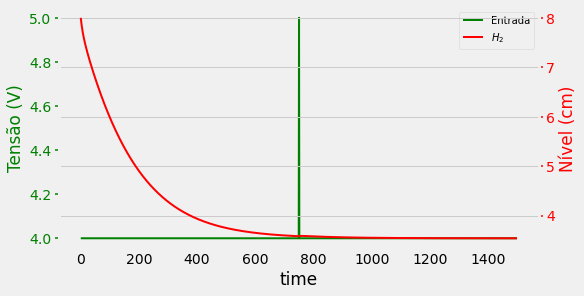

In [123]:
u = signal.unit_impulse(len(t),'mid')
run_rk(t.copy() ,x.copy(), u.copy() , h)

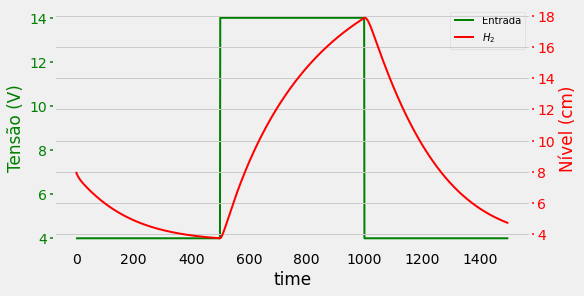

In [124]:
# Pulso
u = 10 * np.append(np.append(np.zeros((math.floor(len(t)/3), 1)), np.full((math.floor(len(t)/3), 1), 1)), np.zeros((math.floor(len(t)/3), 1)))
run_rk(t.copy() ,x.copy(), u.copy() , h)

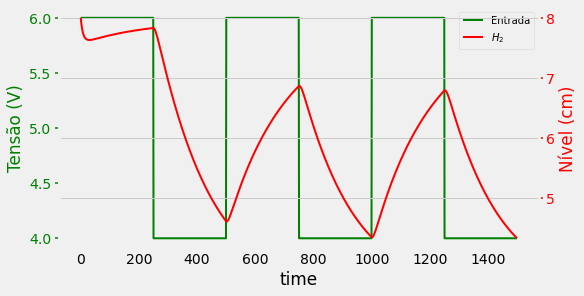

In [125]:
# Pulso
u = 1 * (signal.square(2 * np.pi * .002 * t)+1)
run_rk(t.copy() ,x.copy(), u.copy() , h)

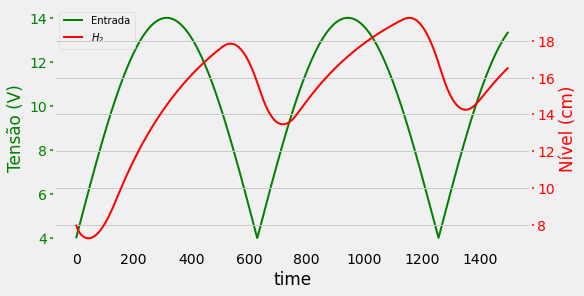

In [126]:
# Senoidal
u = 10 * abs(np.sin(np.array( t * 0.005)))  # np.zeros((len(t), 1))
run_rk(t.copy() ,x.copy(), u.copy() , h)

## Prova de não linearidade

### Resposta ao Degrau com amplitudes diferentes
Caso o sistema fosse linear era de se esperar que o mesmo, ao receber uma entrada duas vezes maior, vesse sua amplitude
aumentada de mesma forma. Porém não é o observado, mesmo em estado estacionário

L: 150; R: 1350


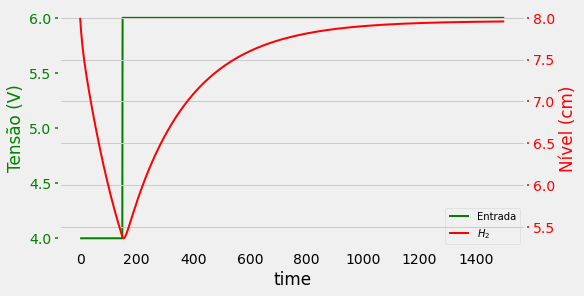

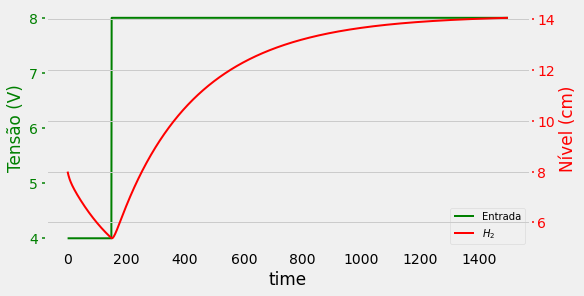

In [128]:
# Degrau
left_size = math.floor(len(t)/10)
right_size = math.floor(len(t) - len(t)/10)
print(f'L: {left_size}; R: {right_size}')
left = np.zeros((left_size, 1))
right = np.ones(right_size)
# print(f'L: {left}; R: {right}')
u = 2 * np.append(left,right)
run_rk(t.copy() ,x.copy(), u.copy() , h)
u = 4 * np.append(left,right)
run_rk(t.copy() ,x.copy(), u.copy() , h)

### Resposta a sequência de pulsos de mesmo período e amplitude
Em diferentes níveis de tensão aplicados a bomba é possível visualizar no gráfico a resposta ao degrais
de mesmo período e amplitude tendo respostas bem diferentes do sistema. Essas diferenças se devem a pontos de operaçôes
distintos.

[0. 0. 0. ... 8. 8. 8.]
SEQUENCE


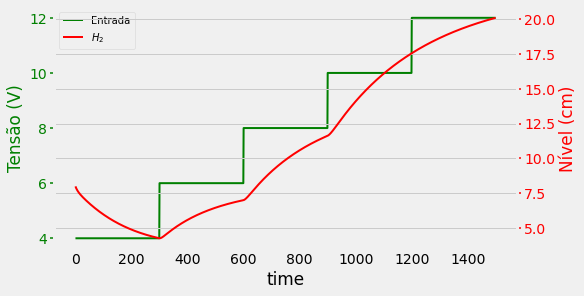

In [127]:
# Sequencia de Degrau
level = np.arange(0, 10, 2)
width = math.floor(len(t)/len(level))
ones = np.ones((1,width))
arr = [ level[i] * j  for i in range(len(level)) for j in ones]
u = np.array((arr)).flatten()
print(u)
run_rk(t.copy() ,x.copy(), u.copy() , h)
print("SEQUENCE")

# Referência
[Trabalho de referência](http://www.ppgee.ufpa.br/ARQUIVOS/teses/TD%2020_2018%20Florindo%20Ant%C3%B4nio%20de%20Carvalho%20Ayres%20Junior.pdf)

[Trabalho de referência 1](http://www.pee.coppe.ufrj.br/index.php/pt/producao-academica/dissertacoes-de-mestrado/2009-1/2009092801-2009092801/file)

[Modelagem de Processos Químicos](https://issuu.com/modelagemsimulacao/docs/0.0_qm8710_2s_2018)

[Tanques Acoplados](https://www.researchgate.net/publication/281295139_Sistema_de_Tanques_Acoplados_e_Desacoplados_STADpara_o_Estudo_de_Controle_e_Automacao_de_Processos_Modelagem_e_Controle)

[Software de Modelagem EMSO](https://pt.slideshare.net/kaiquest/simulador-de-processos-emso)

[Controle e Sistemas](ftp://ftp.dca.fee.unicamp.br/pub/docs/vonzuben/ea932_03/aulas/topico7_03.pdf)